In [1]:
# !pip install stellargraph[demos]
# !pip install tf-nightly

In [1]:
import stellargraph as sg
import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from stellargraph.layer import GCN_LSTM

import datetime
import random
random.seed(45)
tf.random.set_seed(10)

2022-03-15 22:49:28.898781: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 22:49:28.899412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-15 22:49:51.323740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 22:49:51.325994: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 22:49:51.326200: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-F3GKG0K): /proc/driver/nvidia/version does not exist
2022-03-15 22:49:51.346809: I tensorflow/core/platform/cpu_fe

In [2]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [3]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [4]:
def data_preparation(datafile1):
    #Put the file location
    df = pd.read_csv(datafile1)
    
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # TODO: Add buffer and consider train-data for range
    # lat_range = {'min': df.lat.min(), 'max': df.lat.max()}
    # long_range = {'min': df.long.min(), 'max': df.long.max()}
    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)
    means = df[["lat_grid", "long_grid", "pm2_5"]].groupby(['lat_grid', 'long_grid']).mean().reset_index()['pm2_5'].values

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('240min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute

    # only PM2_5
    df = df[['dateTime','lat_grid','long_grid','pm2_5']]
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
#     df = df.fillna(method='ffill')
#     df = df.fillna(method='bfill')
#     df = df.interpolate(limit_direction="both")
#     df = df.interpolate(method='spline', order=3)
#     df = df.fillna(0)
    columns = df.columns
    df = df[columns[2:]]
    df = df.fillna(0)
#     df['means'] = means
    return df

# Fill missing values

In [6]:
# !pip install missingno

In [6]:
# import missingno as msno
# import matplotlib.pyplot as plt
df = data_preparation('PM Datasets/2021-01-23_all.csv')
# msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')

In [7]:
df

dateTime                  480         720         960         1200
lat_grid long_grid                                                
0        21         146.000000    0.000000    0.000000    0.000000
         22         163.010445  131.187048  113.317735  194.578186
1        19         132.193548  160.869565  139.480000  304.500000
         20         133.450980  151.697674  127.581818  266.000000
         21         143.541772  136.545190  125.040650  230.193853
...                        ...         ...         ...         ...
18       23         113.196970  110.247423   78.568182  149.281250
         24         102.646154  144.207547   85.841121  139.301471
19       14         158.200000  162.512195    0.000000    0.000000
         19         189.280000  174.516129  156.033333  246.515152
         20         179.382166  145.768473  182.930348  258.493776

[154 rows x 4 columns]

In [8]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)
# imputed_dataset = imputer.fit_transform(df)

In [9]:
def my_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
#     mask = tf.sign(y_true)
#     print(mask[mask>0])
#     y_pred = y_pred*(mask)
    loss = mse(y_pred[y_true>0], y_true[y_true>0] )
#     loss = mse(tf.reshape(y_true,(-1,)),tf.reshape(y_pred,(-1,)))
#     print(loss)
    return loss

In [10]:
from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imputer=IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=5)

def train_test_split(df, grid_points_indices, train_size, full_train):
#     random.seed(10)
#     train_size = 0.8
    #train-data for range from total grid structure
    points_len = df.shape[0]
    test_size = int(points_len * (1-train_size))
    test_indices = random.sample(list(df.index), test_size)
    train_indices = list(set(df.index) - set(test_indices))
    
    if full_train:
        train_data = df
    else:
        train_data = df.loc[train_indices, :] 
#     imputed_trainset = imputer.fit_transform(train_data)
    train_data['mask'] = 1
    train_data = train_data[[480, 720, 960, 'mask', 1200]]
#     train_data = pd.DataFrame(train_data,index = train_data.index)
    train_data = train_data.reindex(grid_points_indices,fill_value=0)
    train_data = np.array(train_data)

    test_data = df.loc[test_indices, :] 
    test_data['mask'] = 1
    test_data = test_data[[480, 720, 960, 'mask', 1200]]
    test_data = test_data.reindex(grid_points_indices,fill_value=0)
    test_data = np.array(test_data)
    return train_data, test_data

In [11]:
def scale_data(train_data, test_data):
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)
    test_scaled = (test_data - min_pm) / (max_pm - min_pm)
    return train_scaled, test_scaled

In [13]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# train_data, test_data = train_test_split(df, grid_points_indices, train_size=0.8, full_train = False)
# train_data2, test_data2 = train_test_split(df2, grid_points_indices, train_size=0.8)

In [14]:
# train_data = np.hstack((train_data1, train_data2))
# test_data = np.hstack((test_data1, test_data2))

In [12]:
def sequence_data_preparation(seq_len, train_data, test_data): 
    trainX, trainY, testX, testY = [], [], [], []
    i = 0
    while i< train_data.shape[1] - seq_len:
        trainX.append(train_data[:, i : i + seq_len + 1])
        trainY.append(train_data[:, i + seq_len + 1])
        testX.append(test_data[:, i : i + seq_len + 1])
        testY.append(test_data[:, i + seq_len + 1])
        i = i + seq_len + 2
        
    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [16]:
# trainX, trainY, testX, testY  = sequence_data_preparation(3, train_data, test_data)
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)

In [17]:
# def prepare_train_data(df1, df2, grid_points_indices, train_size):
#     train_data1, test_data1 = train_test_split(df1, grid_points_indices, train_size)
#     train_data2, test_data2 = train_test_split(df2, grid_points_indices, train_size)
#     train_data = np.hstack((train_data1, train_data2))
#     test_data = np.hstack((test_data, test_data))
#     print("Train data: ", train_data1.shape)
#     print("Test data: ", test_data1.shape)
#     train_scaled, test_scaled = scale_data(train_data, test_data)
#     trainX, trainY, testX, testY = sequence_data_preparation(
#         seq_len, train_scaled, test_scaled
#     )
#     print(trainX.shape)
#     print(trainY.shape)
#     print(testX.shape)
#     print(testY.shape)
#     return trainX, trainY, testX, testY, train_data

In [13]:
def prepare_train_data(df, grid_points_indices, train_size, full_train):
    train_data, test_data = train_test_split(df, grid_points_indices, train_size, full_train)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)
    train_scaled, test_scaled = scale_data(train_data, test_data)
    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)
    return trainX, trainY, testX, testY, train_data

In [31]:
def train_model(trainX, trainY, testX, testY, train_data, n_epochs):
    cb = TimingCallback()

    history = model.fit(
            trainX,
            trainY,
            epochs = n_epochs,
            batch_size = 1,
            shuffle=True,
            verbose=0,
            validation_data=[testX, testY],
            callbacks=[cb]
        )

    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_scaled = (train_data - min_pm) / (max_pm - min_pm)

    print(
        "Mean Train loss: ",
        sum(tf.sqrt(history.history["loss"]))*max_pm/len(history.history["loss"]),
        "\n Last Train loss: ",
        tf.sqrt(history.history["loss"][-1])*max_pm,
        "\n Mean Test loss:",
        sum(tf.sqrt(history.history["val_loss"]))*max_pm/len(history.history["val_loss"]),
        "\n Last Test loss:",
        tf.sqrt(history.history["val_loss"][-1])*max_pm,
    #     "\nTrain time ", traintime,
        "\n Train time callbacks", sum(cb.logs)
        
    )
    sg.utils.plot_history(history)

In [14]:
def eval(model, testX, testY):
    output = model.predict(trainX)
    # yhat = model.predict(testX)

    ## actual train and test values
    ## Rescale values
    max_pm = train_data.max()
    min_pm = train_data.min()
    train_true = np.array((trainY * (max_pm - min_pm)) + min_pm)
    test_true = np.array((testY * (max_pm - min_pm)) + min_pm)

    ## Rescale model predicted values
    train_output = np.array((output * (max_pm - min_pm)) + min_pm)
    # test_rescpred = np.array((yhat * (max_pm - min_pm)) + min_pm)

    # # Masked predicted values
    # mask_train = tf.sign(trainY)
    mask_test = tf.sign(testY)
    # train_rescpred = train_rescpred*(mask_train)
    test_output = train_output*(mask_test)
    test_mse = my_loss(test_true, train_output)
    test_rmse = tf.sqrt(test_mse)
    print("Test RMSE: ", test_rmse)
    return test_output, test_true

In [15]:
from scipy.spatial.distance import pdist, squareform

lat_range = {'min': 28.486, 'max': 28.72}
long_range = {'min': 77.1, 'max': 77.32}
n_lat_grid = 25
n_long_grid = 25
seq_len = 3

#adjacency matrix
grid_points = pd.read_csv('grid_points_25.csv')
n_grid_points = grid_points.shape[0] 
X = grid_points[["lat_grid", "long_grid"]].to_numpy()
f = lambda u, v: max(abs(u-v))<=1
adj = squareform(pdist(X, f))
eye = np.identity(n_grid_points)
adj = adj+eye
print(adj.shape) 

grid_points = grid_points.pivot_table(index=['lat_grid', 'long_grid'])
grid_points_indices = grid_points.index

(270, 270)


In [33]:
gcn_lstm = GCN_LSTM(
        seq_len=seq_len+1,
        adj=adj,
        gc_layer_sizes=[4, 4],
        gc_activations=["relu", "relu"],
        lstm_layer_sizes=[4, 4],
        lstm_activations=["tanh", "tanh"],
    )
x_input, x_output = gcn_lstm.in_out_tensors()
model = Model(inputs=x_input, outputs=x_output)
opt = tf.optimizers.Adam(learning_rate = 0.01)
model.compile(optimizer=opt, loss=my_loss)
print(model.summary())

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  import sys


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 270, 4)]          0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 270, 4, 1)        0         
 a)                                                              
                                                                 
 reshape_3 (Reshape)         (None, 270, 4)            0         
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73186     
 lution_2 (FixedAdjacencyGra                                     
 phConvolution)                                                  
                                                                 
 fixed_adjacency_graph_convo  (None, 270, 4)           73186     
 lution_3 (FixedAdjacencyGra                               

Train data:  (270, 5)
Test data:  (270, 5)
(1, 270, 4)
(1, 270)
(1, 270, 4)
(1, 270)
Mean Train loss:  tf.Tensor(17.306585, shape=(), dtype=float32) 
 Last Train loss:  tf.Tensor(18.784363, shape=(), dtype=float32) 
 Mean Test loss: tf.Tensor(50.908253, shape=(), dtype=float32) 
 Last Test loss: tf.Tensor(50.73872, shape=(), dtype=float32) 
 Train time callbacks 12.930786300000364


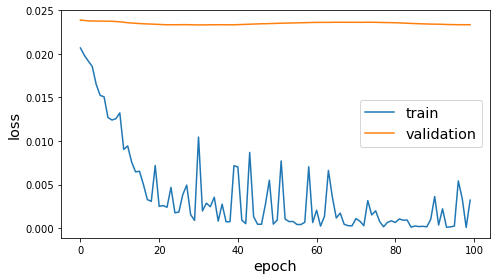

In [34]:
df = data_preparation('PM Datasets/2021-01-23_all.csv')
trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.8, full_train = False)
max_pm = train_data.max()
min_pm = train_data.min()
train_model(trainX, trainY, testX, testY, train_data, n_epochs = 100)

In [24]:
n_epochs = 100
train_loss_array = []
train_rmse_array = []
test_loss_array = []
test_rmse_array = []
x = trainX
y = trainY
x_val = testX
y_val = testY
for epoch in range(n_epochs):
    
    with tf.GradientTape() as tape: # Forward pass
        y_ = model(x, training=True)
        loss = my_loss(y_true=y, y_pred=y_)
    grad = tape.gradient(loss, model.trainable_variables) # Backpropagation
    opt.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights
    train_loss_array.append(loss)
    train_rmse_array.append(tf.sqrt(loss))
#     print(loss)
    
    y_test = model.predict(x_val) # Validation predictions
    test_loss = my_loss(y_true=y_val, y_pred=y_test)
    test_loss_array.append(test_loss)
    test_rmse_array.append(tf.sqrt(test_loss))
#     print(test_loss)

1/1 [==============================] - 0s 45ms/step


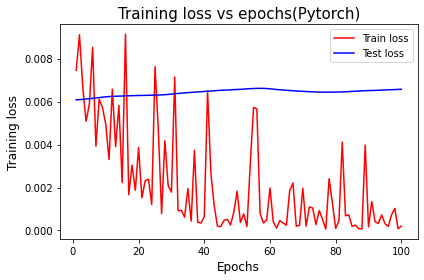

In [35]:
import matplotlib.pyplot as plt
titleFontSize = 15
labelFontSize = 12
tickFontSize = 10
legendFontSize = 10
labelStr = "size = "
yLabel = "% of test points with lower error"
xLabel = "Error %"
count_arr = [i for i in range(1, len(train_loss_array) + 1)]
plt.plot(count_arr, train_loss_array, label = "Train loss", color='red')
plt.plot(count_arr, test_loss_array, label = "Test loss", color='blue')
plt.title("Training loss vs epochs(Pytorch)", fontsize=titleFontSize)
plt.xlabel("Epochs", fontsize=labelFontSize)
plt.ylabel("Training loss", fontsize=labelFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.legend(prop={"size": legendFontSize})
# plt.savefig("pytorch_loss.png")

In [28]:
# print(test_rmse_array[-1])

tf.Tensor(0.08108307403380502, shape=(), dtype=float64)


In [29]:
# 0.08108307403380502*max_pm

26.91668475515063

In [ ]:
#all test result visualization
test_output, test_true = eval(model, trainX, testY)
fig1 = plt.figure(figsize=(15, 8))
a_out = test_output[test_output>0]
a_true = test_true[test_true>0]
plt.plot(a_out, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("grid point")
plt.ylabel("PM2.5")
plt.legend(loc="best", fontsize=10)
plt.show()

In [ ]:
df

In [ ]:
# df = data_preparation('PM Datasets/2020-11-15_all.csv')
# train_data, test_data = train_test_split(df, grid_points_indices, train_size = 0.8, full_train = True)

# for i in range(16, 31):

#     if i<10:
#         datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
#     df = data_preparation(datafile)
#     train_data1, test_data1 = train_test_split(df, grid_points_indices, train_size = 0.8, full_train = True)
#     train_data = np.hstack((train_data, train_data1))
#     test_data = np.hstack((test_data, test_data1))
# for i in range(1, 16):

#     if i<10:
#         datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
#     df = data_preparation(datafile)
#     train_data1, test_data1 = train_test_split(df, grid_points_indices, train_size = 0.8, full_train = True)
#     train_data = np.hstack((train_data, train_data1))
#     test_data = np.hstack((test_data, test_data1))

# print("Train data: ", train_data.shape)
# print("Test data: ", test_data.shape)
# train_scaled, test_scaled = scale_data(train_data, test_data)
# trainX, trainY, testX, testY = sequence_data_preparation(
#     seq_len, train_scaled, test_scaled
# )
# print(trainX.shape)
# print(trainY.shape)
# print(testX.shape)
# print(testY.shape)


In [ ]:
# train_model(trainX, trainY, testX, testY, train_data, 100)

In [ ]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.8, full_train = False)
# # train_model(trainX, trainY, testX, testY, train_data, 50)
# #all test result visualization
# test_output, test_true = eval(model, trainX, testY)
# fig1 = plt.figure(figsize=(15, 8))
# a_out = test_output[test_output>0]
# a_true = test_true[test_true>0]
# plt.plot(a_out, "r-", label="prediction")
# plt.plot(a_true, "b-", label="true")
# plt.xlabel("grid point")
# plt.ylabel("PM2.5")
# plt.legend(loc="best", fontsize=10)
# plt.show()

In [ ]:
# df = data_preparation('PM Datasets/2021-01-23_all.csv')
# trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.8, full_train = False)
# train_model(trainX, trainY, testX, testY, train_data, 60)
# #all test result visualization
# test_output, test_true = eval(model, trainX, testY)
# fig1 = plt.figure(figsize=(15, 8))
# a_out = test_output[test_output>0]
# a_true = test_true[test_true>0]a
# plt.plot(a_out, "r-", label="prediction")
# plt.plot(a_true, "b-", label="true")
# plt.xlabel("grid point")
# plt.ylabel("PM2.5")
# plt.legend(loc="best", fontsize=10)
# plt.show()

In [ ]:
# for i in range(24, 30):

#     if i<10:
#         datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
#     else:
#         datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
#     df = data_preparation(datafile)
# #     if(df.shape[1]) != 12:
# #         continue
#     trainX, trainY, testX, testY, train_data = prepare_train_data(df, grid_points_indices, train_size = 0.8, full_train = False)
#     train_model(trainX, trainY, testX, testY, train_data, 60)
#     test_output, test_true = eval(model, trainX, testY)
#     fig1 = plt.figure(figsize=(6, 6))
#     a_out = test_output[test_output>0]
#     a_true = test_true[test_true>0]
#     plt.plot(a_out, "r-", label="prediction")
#     plt.plot(a_true, "b-", label="true")
#     plt.xlabel("grid point")
#     plt.ylabel("PM2.5")
#     plt.legend(loc="best", fontsize=10)
#     plt.show()